# Custom DecisionTreeRegressor adapted to a linear regression

A [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) can be trained with a couple of possible criterions but it is possible to implement a custom one (see [hellinger_distance_criterion](https://github.com/EvgeniDubov/hellinger-distance-criterion/blob/master/hellinger_distance_criterion.pyx)). See also tutorial [Cython example of exposing C-computed arrays in Python without data copies](http://gael-varoquaux.info/programming/cython-example-of-exposing-c-computed-arrays-in-python-without-data-copies.html) which describes a way to implement fast [cython](https://cython.org/) extensions.

In [1]:
from jyquickhelper import add_notebook_menu

add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
import warnings

warnings.simplefilter("ignore")

## Piecewise data

Let's build a toy problem based on two linear models.

In [4]:
import numpy
import numpy.random as npr

X = npr.normal(size=(1000, 4))
alpha = [4, -2]
t = (X[:, 0] + X[:, 3] * 0.5) > 0
switch = numpy.zeros(X.shape[0])
switch[t] = 1
y = alpha[0] * X[:, 0] * t + alpha[1] * X[:, 0] * (1 - t) + X[:, 2]

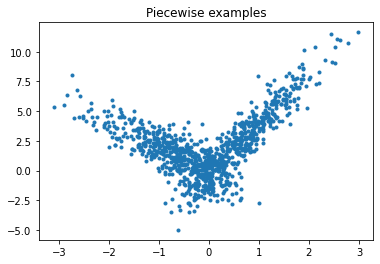

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(X[:, 0], y, ".")
ax.set_title("Piecewise examples");

## DecisionTreeRegressor

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[:, :1], y)

In [7]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=100)
model.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=100)

In [8]:
pred = model.predict(X_test)
pred[:5]

array([ 3.29436256,  0.50924806, -0.07129149,  0.50924806,  2.64957806])

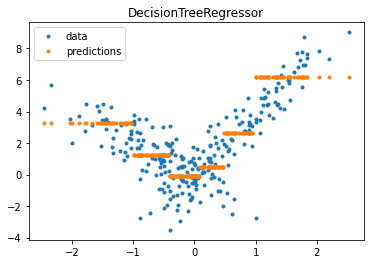

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label="data")
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor")
ax.legend();

## DecisionTreeRegressor with custom implementation

In [10]:
import sklearn
from pyquickhelper.texthelper import compare_module_version

if compare_module_version(sklearn.__version__, "0.21") < 0:
    print("Next step requires scikit-learn >= 0.21")
else:
    print("sklearn.__version__ =", sklearn.__version__)

sklearn.__version__ = 1.1.dev0


In [11]:
from mlinsights.mlmodel.piecewise_tree_regression_criterion import (
    SimpleRegressorCriterion,
)

In [12]:
model2 = DecisionTreeRegressor(
    min_samples_leaf=100, criterion=SimpleRegressorCriterion(X_train)
)
model2.fit(X_train, y_train)

DecisionTreeRegressor(criterion=<mlinsights.mlmodel.piecewise_tree_regression_criterion.SimpleRegressorCriterion object at 0x000001FC680A0BF0>,
                      min_samples_leaf=100)

In [13]:
pred = model2.predict(X_test)
pred[:5]

array([ 2.65757699,  0.37665413, -0.07967816,  0.37665413,  5.57229226])

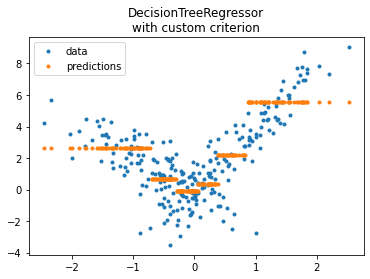

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label="data")
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith custom criterion")
ax.legend();

## Computation time

The custom criterion is not really efficient but it was meant that way. The code can be found in [piecewise_tree_regression_criterion](https://github.com/sdpython/mlinsights/blob/master/src/mlinsights/mlmodel/piecewise_tree_regression_criterion.pyx). Bascially, it is slow because each time the algorithm optimizing the tree needs the class Criterion to evaluate the impurity reduction for a split, the computation happens on the whole data under the node being split. The implementation in [_criterion.pyx](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_criterion.pyx) does it once.

In [15]:
%timeit model.fit(X_train, y_train)

551 µs ± 93.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit model2.fit(X_train, y_train)

43.9 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


A loop is involved every time the criterion of the node is involved which raises a the computation cost of lot. The method ``_mse`` is called each time the algorithm training the decision tree needs to evaluate a cut, one cut involves elements betwee, position ``[start, end[``.

## Better implementation

I rewrote my first implementation to be closer to what *scikit-learn* is doing. The criterion is computed once for all possible cut and then retrieved on demand. The code is below, arrays ``sample_wy_left`` is the cumulated sum of $weight * Y$ starting from the left side (lower *Y*). The loop disappeared.

In [17]:
from mlinsights.mlmodel.piecewise_tree_regression_criterion_fast import (
    SimpleRegressorCriterionFast,
)

model3 = DecisionTreeRegressor(
    min_samples_leaf=100, criterion=SimpleRegressorCriterionFast(X_train)
)
model3.fit(X_train, y_train)
pred = model3.predict(X_test)
pred[:5]

array([ 2.65757699,  0.37665413, -0.07967816,  0.37665413,  5.57229226])

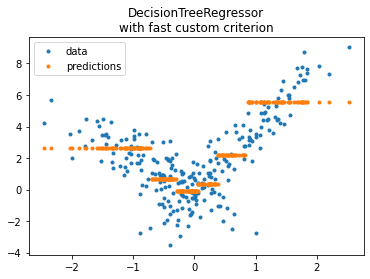

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label="data")
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith fast custom criterion")
ax.legend();

In [19]:
%timeit model3.fit(X_train, y_train)

676 µs ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Much better even though this implementation is currently 3, 4 times slower than scikit-learn's. Let's check with a datasets three times bigger to see if it is a fix cost or a cost.

In [20]:
import numpy

X_train3 = numpy.vstack([X_train, X_train, X_train])
y_train3 = numpy.hstack([y_train, y_train, y_train])

In [21]:
X_train.shape, X_train3.shape, y_train3.shape

((750, 1), (2250, 1), (2250,))

In [22]:
%timeit model.fit(X_train3, y_train3)

1.36 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The criterion needs to be reinstanciated since it depends on the features *X*. The computation does not but the design does. This was introduced to compare the current output with a decision tree optimizing for a piecewise linear regression and not a stepwise regression.

In [23]:
try:
    model3.fit(X_train3, y_train3)
except Exception as e:
    print(e)

X.shape=[750, 1, 0, 0, 0, 0, 0, 0] -- y.shape=[2250, 1, 0, 0, 0, 0, 0, 0]


In [24]:
model3 = DecisionTreeRegressor(
    min_samples_leaf=100, criterion=SimpleRegressorCriterionFast(X_train3)
)
%timeit model3.fit(X_train3, y_train3)

2.03 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Still almost 2 times slower but of the same order of magnitude. We could go further and investigate why or continue and introduce a criterion which optimizes a piecewise linear regression instead of a stepwise regression.

## Criterion adapted for a linear regression

The previous examples are all about decision trees which approximates a function by a stepwise function. On every interval $[r_1, r_2]$, the model optimizes $\sum_i (y_i - C)^2 \mathbb{1}_{ r_1 \leqslant x_i \leqslant r_2}$ and finds the best constant (= the average) approxmating the function on this interval. We would to like to approximate the function by a regression line and not a constant anymore. It means minimizing $\sum_i (y_i - X_i \beta)^2 \mathbb{1}_{ r_1 \leqslant x_i \leqslant r_2}$. Doing this require to change the criterion used to split the space of feature into buckets and the prediction function of the decision tree which now needs to return a dot product.

In [25]:
from mlinsights.mlmodel.piecewise_tree_regression import PiecewiseTreeRegressor

piece = PiecewiseTreeRegressor(criterion="mselin", min_samples_leaf=100)
piece.fit(X_train, y_train)

PiecewiseTreeRegressor(min_samples_leaf=100)

In [26]:
pred = piece.predict(X_test)
pred[:5]

array([3.80559618, 0.45086204, 0.42563158, 0.44940565, 3.57423704])

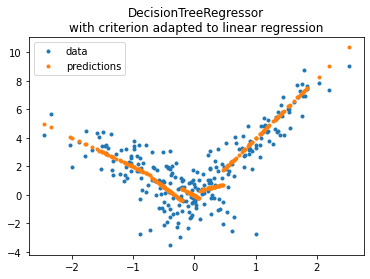

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label="data")
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith criterion adapted to linear regression")
ax.legend();

The coefficients for the linear regressions are kept into the following attribute:

In [28]:
piece.betas_

array([[-2.05163528, -0.07590713],
       [-3.28097357, -1.07747849],
       [-2.37373495, -0.05126022],
       [ 1.10248486,  0.20358196],
       [ 4.21766561, -0.2568136 ]])

Mapped to the following leaves:

In [29]:
piece.leaves_index_, piece.leaves_mapping_

([1, 4, 5, 7, 8], {1: 745, 4: 746, 3: 748, 0: 749, 2: 739})

We can get the leave each observation falls into:

In [30]:
piece.predict_leaves(X_test)[:5]

array([0, 3, 2, 3, 4])

The training is quite slow as it is training many linear regression each time a split is evaluated.

In [31]:
%timeit piece.fit(X_train, y_train)

26.9 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit piece.fit(X_train3, y_train3)

105 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It works but it is slow, slower than the slow implementation of the standard criterion for decision tree regression.

## Next

PR [Model trees (M5P and co)](https://github.com/scikit-learn/scikit-learn/issues/13106) and issue [Model trees (M5P)](https://github.com/scikit-learn/scikit-learn/pull/13732) propose an implementation a piecewise regression with any kind of regression model. It is based on [Building Model Trees](https://github.com/ankonzoid/LearningX/tree/master/advanced_ML/model_tree>). It fits many models to find the best splits and should be slower than this implementation in the case of a decision tree regressor associated with linear regressions.